#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the IMD dataset that can be easily downloaded using Keras. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [0]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

Let's also get the word indexs (word to word-id)

*   List item
*   List item



In [0]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [0]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [62]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [63]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [0]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

Since the model performs a binary classification task, we use cross-entropy as loss.

In [0]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [67]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [68]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 30s 151ms/step - loss: 0.7086 - accuracy: 0.5551 - val_loss: 0.7139 - val_accuracy: 0.5053
Epoch 2/10
196/196 [==============================] - 28s 145ms/step - loss: 0.6734 - accuracy: 0.6222 - val_loss: 0.6660 - val_accuracy: 0.6089
Epoch 3/10
196/196 [==============================] - 28s 145ms/step - loss: 0.6277 - accuracy: 0.6881 - val_loss: 0.6166 - val_accuracy: 0.6418
Epoch 4/10
196/196 [==============================] - 28s 144ms/step - loss: 0.5913 - accuracy: 0.7035 - val_loss: 0.7146 - val_accuracy: 0.5438
Epoch 5/10
196/196 [==============================] - 28s 145ms/step - loss: 0.6108 - accuracy: 0.6738 - val_loss: 0.6249 - val_accuracy: 0.6383
Epoch 6/10
196/196 [==============================] - 28s 145ms/step - loss: 0.5578 - accuracy: 0.7307 - val_loss: 0.6075 - val_accuracy: 0.6541
Epoch 7/10
196/196 [==============================] - 28s 145ms/step - loss: 0.5113 - accuracy: 0.7592 - val_loss: 0.5942 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 7s - loss: 0.3811 - accuracy: 0.8472
accuracy: 84.72%


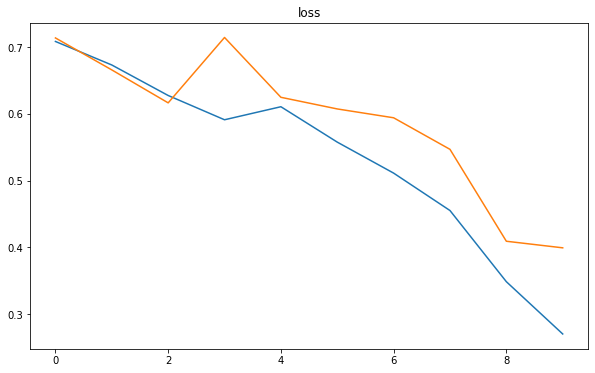

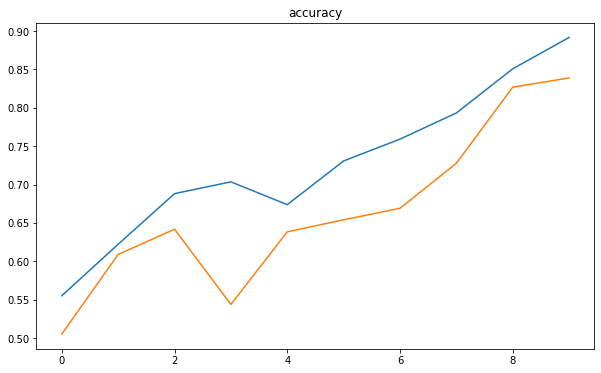

In [69]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##Exercise 4.1: LSTM and GRU
**To complete**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**To complete**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion below*

In [0]:
model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(48))
model_lstm.add(keras.layers.Dense(1, activation="sigmoid"))

In [0]:
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [82]:
model_lstm.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_22 (LSTM)               (None, 48)                11328     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 49        
Total params: 111,377
Trainable params: 111,377
Non-trainable params: 0
_________________________________________________________________


In [83]:
history_lstm = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 94s 480ms/step - loss: 0.5026 - accuracy: 0.7311 - val_loss: 0.3161 - val_accuracy: 0.8662
Epoch 2/10
196/196 [==============================] - 99s 505ms/step - loss: 0.2522 - accuracy: 0.9036 - val_loss: 0.3033 - val_accuracy: 0.8718
Epoch 3/10
196/196 [==============================] - 98s 498ms/step - loss: 0.2158 - accuracy: 0.9192 - val_loss: 0.3432 - val_accuracy: 0.8722
Epoch 4/10
196/196 [==============================] - 98s 502ms/step - loss: 0.1559 - accuracy: 0.9454 - val_loss: 0.3209 - val_accuracy: 0.8670
Epoch 5/10
196/196 [==============================] - 98s 498ms/step - loss: 0.1611 - accuracy: 0.9432 - val_loss: 0.3389 - val_accuracy: 0.8590
Epoch 6/10
196/196 [==============================] - 98s 498ms/step - loss: 0.1230 - accuracy: 0.9598 - val_loss: 0.4269 - val_accuracy: 0.8658
Epoch 7/10
196/196 [==============================] - 98s 499ms/step - loss: 0.1093 - accuracy: 0.9636 - val_loss: 0.3718 - val_ac

391/391 - 18s - loss: 0.4476 - accuracy: 0.8609
accuracy: 86.09%


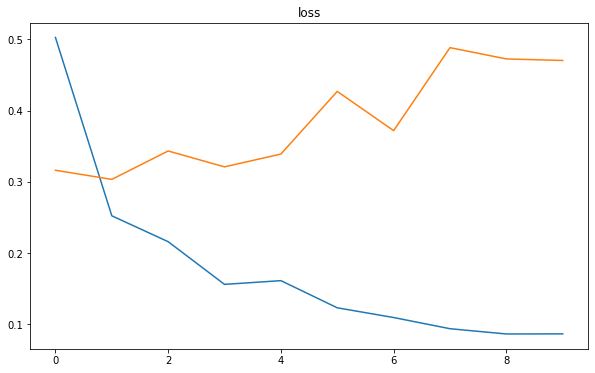

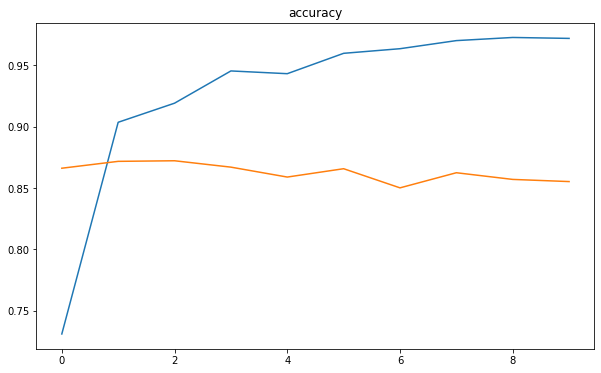

In [84]:
plot_loss(history_lstm)

plot_accuracy(history_lstm)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

In [0]:
model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(1, activation="sigmoid"))

In [0]:
model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [98]:
model_gru.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                1344      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [99]:
history_gru = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 52s 268ms/step - loss: 0.5427 - accuracy: 0.7018 - val_loss: 0.3605 - val_accuracy: 0.8444
Epoch 2/10
196/196 [==============================] - 56s 284ms/step - loss: 0.2898 - accuracy: 0.8846 - val_loss: 0.3200 - val_accuracy: 0.8696
Epoch 3/10
196/196 [==============================] - 56s 286ms/step - loss: 0.2226 - accuracy: 0.9176 - val_loss: 0.3391 - val_accuracy: 0.8640
Epoch 4/10
196/196 [==============================] - 56s 287ms/step - loss: 0.1884 - accuracy: 0.9335 - val_loss: 0.3585 - val_accuracy: 0.8665
Epoch 5/10
196/196 [==============================] - 56s 285ms/step - loss: 0.1580 - accuracy: 0.9467 - val_loss: 0.3770 - val_accuracy: 0.8565
Epoch 6/10
196/196 [==============================] - 59s 300ms/step - loss: 0.1391 - accuracy: 0.9536 - val_loss: 0.3988 - val_accuracy: 0.8614
Epoch 7/10
196/196 [==============================] - 56s 286ms/step - loss: 0.1273 - accuracy: 0.9582 - val_loss: 0.7121 - val_ac

391/391 - 12s - loss: 0.4442 - accuracy: 0.8575
accuracy: 85.75%


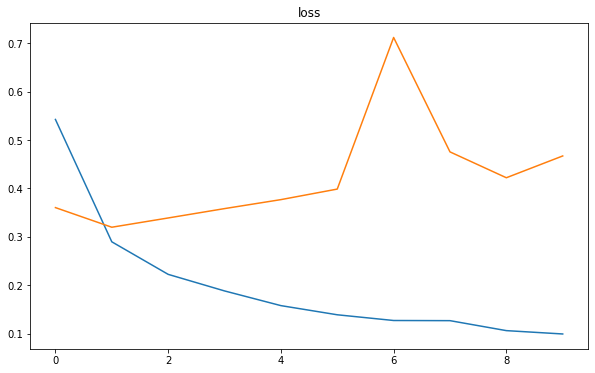

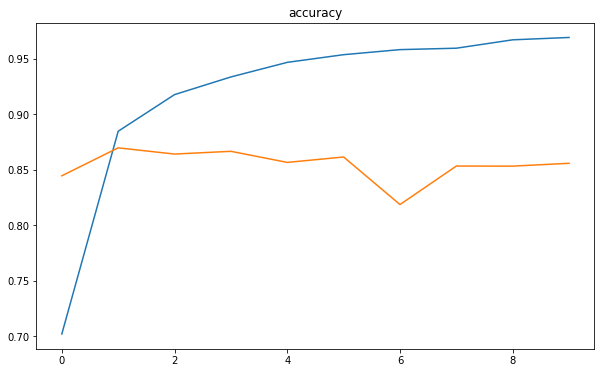

In [100]:
plot_loss(history_gru)

plot_accuracy(history_gru)

scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))

I implemented the model with LSTM layer with 32 units and the accuracy was 85.01%, for each epoch the training time was 74s on average. After I implemented this model with 16 units and the accuracy was 85.98%, and for each epoch the training time was 60s on average. Finally I implemented this model with 48 units and the accuracy was 86.09%, and for each epoch the training time was 98s on average. 

I implemented the model with GRU layer with 32 units and the accuracy was 85.78%, for each epoch the training time was 64s on average. After I implemented this model with 48 units and the accuracy was 85.28%, and for each epoch the training time was 78s on average. Finally I implemented this model with 16 units and the accuracy was 85.75%, and for each epoch the training time was 56s on average. 

Both models (LSTM and GRU) with 32 units are better than Simple RNN in terms of accuracy but they are slower than Simple RNN. 
LSTM model is better than GRU model in terms of accuracy but it is slower. 
Both models have no significant differences and all models present the overfitting problem.



```
# This is formatted as code
```

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [24]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 86s 548ms/step - loss: 0.6226 - accuracy: 0.6731 - val_loss: 0.4526 - val_accuracy: 0.7984
Epoch 2/10
157/157 [==============================] - 84s 537ms/step - loss: 0.3671 - accuracy: 0.8490 - val_loss: 0.3351 - val_accuracy: 0.8566
Epoch 3/10
157/157 [==============================] - 84s 535ms/step - loss: 0.2578 - ac

391/391 - 22s - loss: 0.4349 - accuracy: 0.8526
accuracy: 85.26%


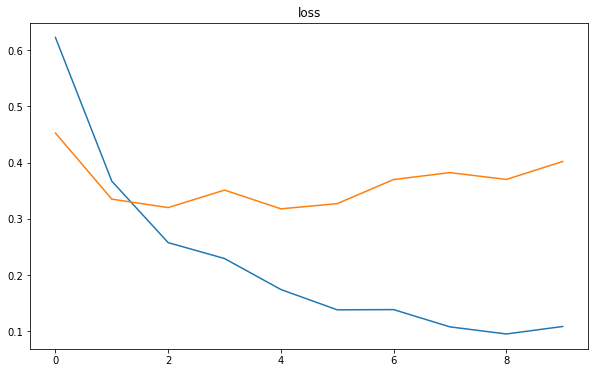

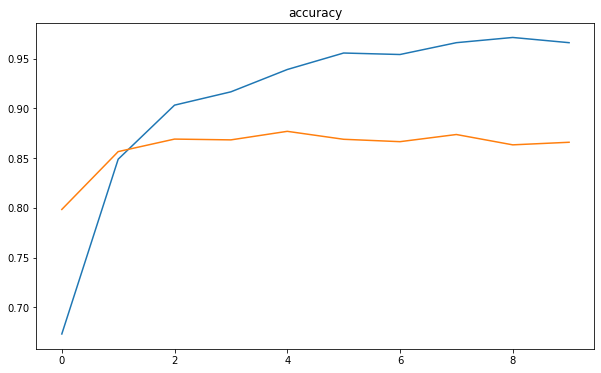

In [25]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##Exercise 4.2: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**To complete**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue. Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion below*

I first tried to add Dropout to the output layer with different probability (0.2, 0.5, 0.8) but there was already the overfitting issue. So I also added Dropout to the input layer with different probability and I solved the overfitting problem a bit adding Dropout to the input and output layers with 0.8 of probability. I tried to change the number of units from 32 to 16 and it performed better. I also tried to reduce and increase the batch_size (first 64, after 256) but without good results so the level of accuracy definitively obtained with the following model is 88.17%

In [56]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(16)))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_33 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 32)                3456      
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 103,489
Trainable params: 103,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 70s 446ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss

391/391 - 18s - loss: 0.2814 - accuracy: 0.8817
accuracy: 88.17%


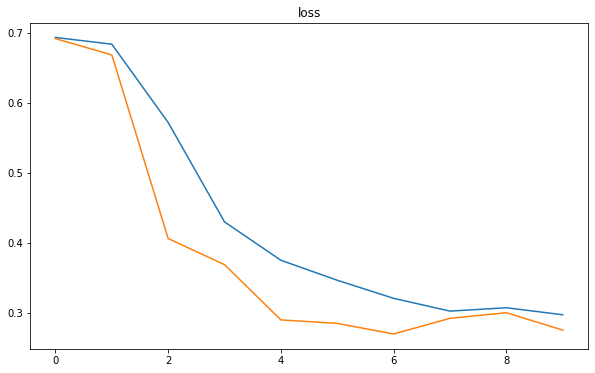

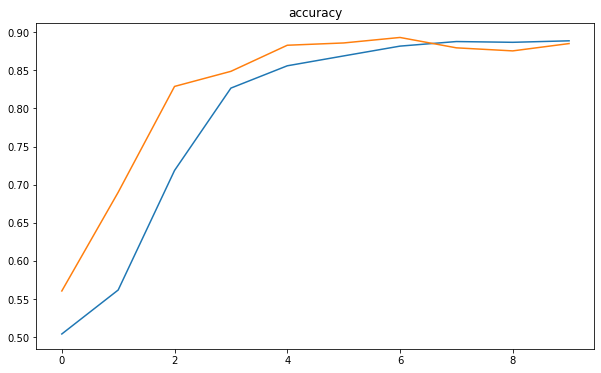

In [57]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))